## From REST to Reasoning: Ingest, Index and Query with dlt and Cognee

### Taxi dataset example: 

* `Cognee` is an open-source python library, connects data points and establishes ground truths to improve the accuracy of your AI agents. 

* `Kuzu` is an open-source embedded, scalable, blazing fast graph dataset.

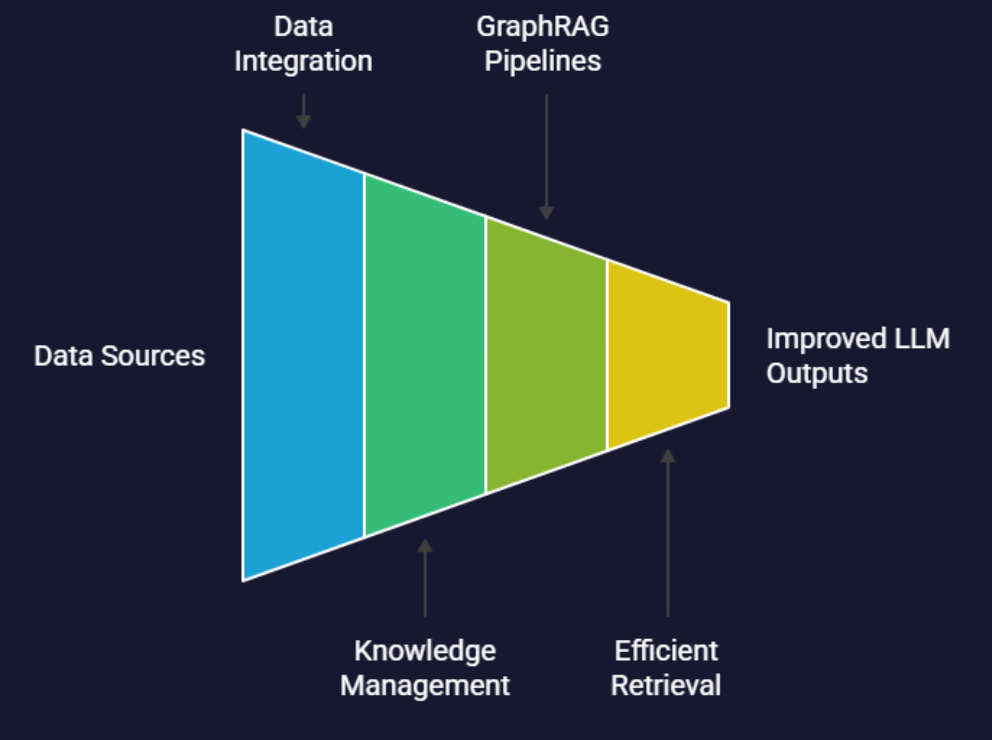

### 1. Importing required Libraries

In [ ]:
import os
import dlt 
import requests
import pandas as pd


from datetime import datetime 
from dotenv import load_dotenv


# loading environment variables from .env file
load_dotenv()


# Setup
os.environ["LLM_API_KEY"] = os.environ.get("OPENAI_API_KEY")
os.environ["GRAPH_DATABASE_PROVIDER"] = "kuzu"

In [2]:
import cognee
from cognee.shared.logging_utils import get_logger, ERROR
from cognee.api.v1.visualize.visualize import visualize_graph
from cognee.api.v1.search import SearchType
from cognee.modules.engine.models import NodeSet


2025-07-09T13:39:42.720874 [info     ] Logging initialized            [cognee.shared.logging_utils] cognee_version=0.2.0 os_info='Windows 10 (10.0.26100)' python_version=3.10.18 structlog_version=25.4.0

2025-07-09T13:39:42.726024 [info     ] Want to learn more? Visit the Cognee documentation: https://docs.cognee.ai [cognee.shared.logging_utils]

HTTP Request: GET https://raw.githubusercontent.com/BerriAI/litellm/main/model_prices_and_context_window.json "HTTP/1.1 200 OK"


### 2. Loading Dataset

IN this example, we'll request data from an API that serves the `NYC Taxi dataset`. For these purposes we created an API that can serve the data: 

#### API documentation:

* **Data:** Comes in pages of 1000 record

* **Pagination:** When there is no more data, the API returns an empty page. 

* **Details:**
    * **Method:** `GET` 

    * **URL:** `https://us-central1-dlthub-analytics.cloudfunctions.net/data_engineering_zoomcamp_api`

    * **Parameters:**
    
        * `page`: Integer (page number), default to `1`. 

Here's how we design our requester: 

1. `Request page by page`: Until we hit an empty page. Since we don't know how much data is behind the API, we must assume it could be a little as 1000 records or as muc has 10GB.

2. `Use a generator:` to handle this effeciently and avoid loading all data into memory. 

### 3. Preprocessing the Data

#### We'll be partitioning our data in our own way

1. first_10_days
2. second_10_days
3. last_10 days

We'll be doing this manually for clarity, but dlt also supports partitioning

In [3]:
# Setp-1: Create a Dlt resource
@dlt.resource(write_disposition="replace", name="zoomcamp_data")
def zoomcamp_data():
    url = "https://us-central1-dlthub-analytics.cloudfunctions.net/data_engineering_zoomcamp_api"
    response = requests.get(url)
    data = response.json()

    # Convert the data to a DataFrame
    df = pd.DataFrame(data)
    # Convert the 'Trip_Pickup_DateTime' column to datetime
    df['Trip_Pickup_DateTime'] = pd.to_datetime(df['Trip_Pickup_DateTime'])

    # Define the buckets 
    df['tag'] = pd.cut(
    df['Trip_Pickup_DateTime'],
    bins=[
        pd.Timestamp("2009-06-01"),
        pd.Timestamp("2009-06-10"),
        pd.Timestamp("2009-06-20"),
        pd.Timestamp("2009-06-30")
    ],
    labels=["first_10_days", "second_10_days", "last_10_days"],
    right=False
)
    
    # Drop rows not in specified range
    df = df[df['tag'].notnull()]
    yield df

In [4]:
# Step-2: Create a Dlt pipeline 
pipeline = dlt.pipeline(
    pipeline_name="zoomcamp_data_pipeline",
    destination="duckdb",
    dataset_name="zoomcap_tagged_data"
)

# Step-3: Run the pipeline
load_info = pipeline.run(zoomcamp_data())

print(pipeline.last_trace)

2025-07-09 14:40:14,695|[WARNING]|30268|27764|dlt|logger.py|wrapper:24|In schema `zoomcamp_data`: The following columns in table 'zoomcamp_data' did not receive any data during this load and therefore could not have their types inferred:
  - rate_code
  - mta_tax

Unless type hints are provided, these columns will not be materialized in the destination.
One way to provide type hints is to use the 'columns' argument in the '@dlt.resource' decorator.  For example:

@dlt.resource(columns={'rate_code': {'data_type': 'text'}})


Run started at 2025-07-09 13:40:11.655288+00:00 and COMPLETED in 3.36 seconds with 4 steps.
Step extract COMPLETED in 2.85 seconds.

Load package 1752068412.043379 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 0.11 seconds.
Normalized data for the following tables:
- zoomcamp_data: 998 row(s)

Load package 1752068412.043379 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 0.27 seconds.
Pipeline zoomcamp_data_pipeline load step completed in 0.23 seconds
1 load package(s) were loaded to destination duckdb and into dataset zoomcap_tagged_data
The duckdb destination used duckdb:///p:\Projects\LLM-ZoomCamp\workshops\dlt\zoomcamp_data_pipeline.duckdb location to store data
Load package 1752068412.043379 is LOADED and contains no failed jobs

Step run COMPLETED in 3.35 seconds.
Pipeline zoomcamp_data_pipeline load step completed in 0.23 seconds
1 load package(s) were loaded to 

In [5]:
dataset = pipeline.dataset().zoomcamp_data.df()

In [6]:
dataset 

,end_lat,end_lon,fare_amt,passenger_count,payment_type,start_lat,start_lon,tip_amt,tolls_amt,total_amt,trip_distance,trip_dropoff_date_time,trip_pickup_date_time,store_and_forward,surcharge,vendor_name,tag
0,40.742963,-73.980072,45.0,1,Credit,40.641525,-73.787442,9.0,4.15,58.15,17.52,2009-06-14 23:48:00,2009-06-14 23:23:00,NaN,0.0,VTS,second_10_days
1,40.740187,-74.005698,6.5,1,Credit,40.722065,-74.009767,1.0,0.00,8.50,1.56,2009-06-18 17:43:00,2009-06-18 17:35:00,NaN,1.0,VTS,second_10_days
2,40.718043,-74.004745,12.5,5,Credit,40.761945,-73.983038,2.0,0.00,15.50,3.37,2009-06-10 18:27:00,2009-06-10 18:08:00,NaN,1.0,VTS,second_10_days
3,40.739637,-73.985233,4.9,1,CASH,40.749802,-73.992247,0.0,0.00,5.40,1.11,2009-06-14 23:58:00,2009-06-14 23:54:00,NaN,0.5,VTS,second_10_days
4,40.730032,-73.852693,25.7,1,CASH,40.776825,-73.949233,0.0,4.15,29.85,11.09,2009-06-13 13:23:00,2009-06-13 13:01:00,NaN,0.0,VTS,second_10_days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,40.742998,-73.919065,6.9,1,CASH,40.743523,-73.918735,0.0,0.00,6.90,1.83,2009-06-10 06:23:00,2009-06-10 06:16:00,NaN,0.0,VTS,second_10_days
994,40.731953,-73.985330,7.3,1,CASH,40.733143,-74.006408,0.0,0.00,7.80,1.59,2009-06-10 05:11:00,2009-06-10 05:02:00,NaN,0.5,VTS,second_10_days
995,40.712640,-73.998870,5.7,1,CASH,40.711865,-74.010158,0.0,0.00,5.70,0.79,2009-06-13 12:45:00,2009-06-13 12:37:00,NaN,0.0,VTS,second_10_days
996,40.732998,-74.007113,7.3,2,CASH,40.744658,-73.992063,0.0,0.00,7.80,1.87,2009-06-09 21:34:00,2009-06-09 21:25:00,NaN,0.5,VTS,first_10_days


In [7]:
dataset['tag'].value_counts()

tag
first_10_days     481
second_10_days    295
last_10_days      222
Name: count, dtype: int64

### 4. Let's load data into Cognee:

Here, I am using `cognee.add()` and then `cognee.cognify()` directly.

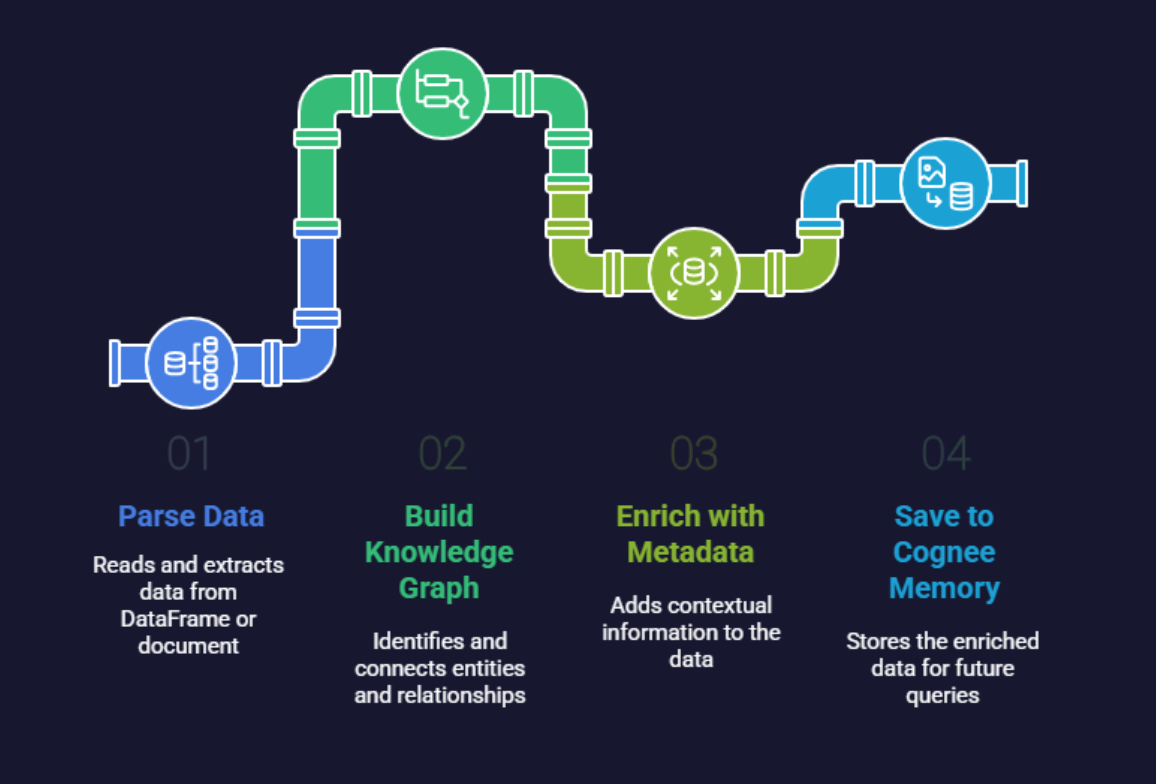

In [10]:
async def main():
    await cognee.prune.prune_data()
    await cognee.prune.prune_system(metadata=True)

    # Add the first 10 days
    df_set1 = dataset.loc[dataset["tag"] == "first_10_days"]
    df_set1.drop(columns=["tag"], inplace=True)
    df_set1 = df_set1.to_json(orient="records", lines=False)
    await cognee.add(df_set1, node_set=["first_10_days"])

    # Add the second 10 days
    df_set2 = dataset.loc[dataset["tag"] == "second_10_days"]
    df_set2.drop(columns=["tag"], inplace=True)
    df_set2 = df_set2.to_json(orient="records", lines=False)
    await cognee.add(df_set2, node_set=["second_10_days"])

    # Add the last 10 days
    df_set3 = dataset.loc[dataset["tag"] == "last_10_days"]
    df_set3.drop(columns=["tag"], inplace=True)
    df_set3 = df_set3.to_json(orient="records", lines=False)
    await cognee.add(df_set3, node_set=["last_10_days"])

    # Congify: it will create the graph
    await cognee.cognify()

    # Graph path
    visualize_path = "./graphs/graph_visualization.html"
    await visualize_graph(visualize_path)

Run the `main()` function. It might take some time....

In [11]:
await main()


2025-07-09T13:47:20.400810 [info     ] Cleared all data from graph while preserving structure [cognee.shared.logging_utils]
2025-07-09T13:47:20.542799 [info     ] Deleted Kuzu database files at P:\Projects\LLM-ZoomCamp\.venv\Lib\site-packages\cognee\.cognee_system\databases\cognee_graph_kuzu [cognee.shared.logging_utils]
2025-07-09T13:47:20.743352 [info     ] Database deleted successfully. [cognee.shared.logging_utils]C:\Users\Karthik\AppData\Local\Temp\ipykernel_30268\2949240743.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_set1.drop(columns=["tag"], inplace=True)

2025-07-09T13:47:21.209098 [info     ] Pipeline run started: `babac0d8-084b-56ff-8c5b-713f8da4c296` [run_tasks(tasks: [Task], data)]

User 27af47d1-ff8c-42d8-8ea2-824b2fec8033 has registered.



2025-07-09T13:47:21.400148 [info     ] Coroutine task started: `resolve_data_directories` [run_tasks_base]
2025-07-09T13:47:21.573386 [info     ] Coroutine task started: `ingest_data` [run_tasks_base]
2025-07-09T13:47:22.339918 [info     ] Coroutine task completed: `ingest_data` [run_tasks_base]
2025-07-09T13:47:22.506201 [info     ] Coroutine task completed: `resolve_data_directories` [run_tasks_base]
2025-07-09T13:47:22.684006 [info     ] Pipeline run completed: `babac0d8-084b-56ff-8c5b-713f8da4c296` [run_tasks(tasks: [Task], data)]C:\Users\Karthik\AppData\Local\Temp\ipykernel_30268\2949240743.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_set2.drop(columns=["tag"], inplace=True)

2025-07-09T13:47:22.952665 [info     ] Pipeline run started: `babac0d8-084b-56ff-8c5b-713f8da4c296` [run_tasks(

#### Search 

In [ ]:
async def search_congnee(query, node_set, query_type=SearchType.GRAPH_COMPLETION):
    answer = await cognee.search(
        query_text=query,
        query_type=query_type,
        node_type=NodeSet,
        node_name=node_set,
        top_k=5 # limit search for retrieval
    )
    return answer

In [13]:
results = await search_congnee(
    "What's in this knowledge graph?",
    node_set=["first_10_days"]
)

15:03:40 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: openai/text-embedding-3-large
selected model name for cost calculation: openai/text-embedding-3-large15:03:40 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: openai/text-embedding-3-large
selected model name for cost calculation: openai/text-embedding-3-large15:03:40 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: openai/text-embedding-3-large
selected model name for cost calculation: openai/text-embedding-3-large15:03:40 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: openai/text-embedding-3-large
selected model name for cost calculation: openai/text-embedding-3-large15:03:40 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: openai/text-embedding-3-large
selected model name for cost calculation: openai/text-embedding-3-large15:03:40 - LiteLLM:INFO: cost_calcu

In [17]:
print(results[0])

The knowledge graph contains data related to taxi trips, including details such as pickup and drop-off dates and times, coordinates, fare amounts, passenger counts, payment methods, tips, tolls, and vendor names (specifically "VTS"). It includes trip information for multiple dates in June 2009, with connections to specific dates that represent the trip data.
